In [ ]:
!pip install transliterate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from transliterate import translit
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

В начале экпортируем данные и создаем изначальный датафрейм

In [ ]:
import os

def to_latin(s):
  """Convert letters in *s* from Cyrillic to Latin."""
  return translit(s, 'ru', reversed=True)

local_filename = "processed_2018.csv"
url = "https://boodata.s3.eu-central-1.amazonaws.com/processed_2018.csv"

if not os.path.exists(local_filename): 
   df = pd.read_csv(url)
   df.to_csv(local_filename, index=False) 
   if False:                   
      df.to_excel("copy.xlsx") 

df = pd.read_csv(local_filename,                  
                 dtype={'ok1': int, 'region': int}) 
df = df.set_index("inn")                            
df.insert(0, "title_en", df.title.map(to_latin))    
df.head()

,title_en,title,org,okpo,okopf,okfs,okved,unit,ok1,ok2,...,cf_loan_in,cf_eq_in_1,cf_eq_in_2,cf_bond_in,cf_fin_out,cf_eq_out,cf_div_out,cf_debt_out,cf_fin,cf
inn,,,,,,,,,,,,,,,,,,,,,
7736050003,GAZPROM,ГАЗПРОМ,ПУБЛИЧНОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО,40778,12247,41,46.71,384,46,71.0,...,736.365,0.0,0.000,39.995,818.860,0.0,186.871,631.990,-42.053,-153.083
7706107510,"NEFTJaNAJa KOMPANIJa ""ROSNEFT'""","НЕФТЯНАЯ КОМПАНИЯ ""РОСНЕФТЬ""",ПУБЛИЧНОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО,44428,12247,49,19.20,384,19,20.0,...,3331.053,0.0,0.000,69.991,3338.429,0.0,218.156,3120.272,62.616,480.928
7708503727,ROSSIJSKIE ZhELEZNYE DOROGI,РОССИЙСКИЕ ЖЕЛЕЗНЫЕ ДОРОГИ,ОТКРЫТОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО,83262,47,12,49.10,384,49,10.0,...,659.647,0.0,77.922,107.332,658.777,0.0,8.755,642.441,202.211,-11.165
8602060555,SURGUTNEFTEGAZ,СУРГУТНЕФТЕГАЗ,ПУБЛИЧНОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО,5753490,12247,16,06.10.1,384,6,10.0,...,0.000,0.0,0.000,0.000,31.530,0.0,31.530,0.000,-31.530,7.469
7705630445,ROSNEFTEGAZ,РОСНЕФТЕГАЗ,АКЦИОНЕРНОЕ ОБЩЕСТВО,75535279,12267,12,70.10.2,384,70,10.0,...,0.000,0.0,0.000,0.000,65.447,0.0,65.447,0.000,-65.447,4.660


In [ ]:
df.to_excel('financial_data_for_rus_companies_2018.xlsx')

In [ ]:
columns = list(df)

Из всего датафрейма были отобраны IT компании, зарегистрированные на территории Москвы, Питера и Московской области. 

Выбор пал на данный вид компаний, поскольку они развиваются достаточно быстро и часто привлекают внешние средства, а значит в определенный период времени объем их заемных средств мог превышать размер собственных. В данной работе компании рассматриваются с точки зрения кредитора, которому необходимо оценить их кредитоспособность. Одним из критериев оценки является коэффициент Альтмана, подробнее о нем будет написано ниже. 

Один из вопросов, на которые отвечает данная работа: каким компаниям из выборки скорее всего не одобрили бы кредит?

In [ ]:
# создание списков с необходимыми параметрами. 63 оквед - деятельность в сфере информационных технологий
# регионы: 77-мск 78-спб 50-МО

industry = [63] 
region = [50, 78, 77]
df_sort = df.loc[df['region'].isin(region)]
df_total = df_sort[ df_sort['ok1'].isin(industry)]

# Удаление ненужных столбцов

df_total = df_total.drop(['org', 'okpo', 'okopf', 'okfs', 'okved', 'unit', 'ok3', 'ok1', 'ok2','of','of_lag', 'ta_fix_fin', 'ta_fix_fin_lag', 
                          'ta_fix', 'ta_fix_lag', 'inventory', 'inventory_lag', 'receivables', 'receivables_lag', 
                          'ta_nonfix_fin_lag', 'cash', 'cash_lag',  'ta_nonfix_lag',  'ta_lag', 'retained_earnings',
                          'retained_earnings_lag', 'tp_capital', 'tp_capital_lag', 'debt_long_lag', 'tp_long_lag',
                           'debt_short_lag', 'payables', 'payables_lag', 'tp_short_lag', 'tp', 'tp_lag',
                          'sales_lag', 'costs', 'costs_lag', 'profit_oper_lag', 'exp_interest', 'exp_interest_lag',
                          'profit_before_tax_lag', 'profit_after_tax_lag', 'cf_oper_in', 'cf_oper_in_sales', 'cf_oper_out',
                          'paid_to_supplier', 'paid_to_worker', 'paid_interest', 'paid_profit_tax', 'cf_oper', 'cf_inv_in', 'cf_inv_out',
                          'paid_fa_investment', 'cf_inv', 'cf_fin_in' ,'cf_loan_in', 'cf_eq_in_1', 'cf_eq_in_2', 'cf_bond_in', 'cf_fin_out',
                          'cf_eq_out', 'cf_div_out', 'cf_debt_out', 'cf_fin', 'cf'], axis = 1)
df_total.head()

,title_en,title,region,ta_nonfix_fin,ta_nonfix,ta,debt_long,tp_long,debt_short,tp_short,sales,profit_oper,profit_before_tax,profit_after_tax
inn,,,,,,,,,,,,,,
7743001840,MEJL.RU,МЭЙЛ.РУ,77,5.398,15.962,148.966,5.544,5.593,2.50,14.184,43.520,7.428,7.345,5.839
7708119944,SIBIRSKAJa INTERNET KOMPANIJa,СИБИРСКАЯ ИНТЕРНЕТ КОМПАНИЯ,77,0.690,25.699,40.346,5.000,5.055,0.01,31.316,49.298,3.495,2.635,2.003
7842349892,V KONTAKTE,В КОНТАКТЕ,78,9.819,17.333,22.512,0.000,0.014,0.00,2.768,19.309,8.273,8.505,7.059
7743529527,RN-KART,РН-КАРТ,77,2.472,20.069,20.368,0.000,0.020,0.00,20.317,9.716,0.400,0.431,0.330
7706812159,NATsIONAL'NAJa SISTEMA PLATEZhNYH KART,НАЦИОНАЛЬНАЯ СИСТЕМА ПЛАТЕЖНЫХ КАРТ,77,0.000,16.429,19.173,0.000,0.005,0.00,4.829,11.877,5.651,6.103,4.763


Целью данной работы будет оценка кредитоспосности предприятия по четырехфакторной модели Альтмана.
Основная формула: Z=6,56∗ОА/А+3,26∗Roa+6,72∗ОП/А+1,05∗СК/ЗК

где: 

​ОА/​​А – оборотный капитал/активы (уровень платежеспособности)

Roa​ – чистая прибыль/активы

​ОП/А​ – операционная прибыль/активы (коэффициент базовой прибыльности активов - BEP (basic earnng power))

​СК​/​ЗК – собственный капитал/заемный капитал (equity_to_debt)

Интерпретация результатов:

Z от 0 до 1,1 - высокая вероятность банкротства

Z от 1,1 до 2,6 - вероятность в пределах 50% 

Z равный 2,6 и более -  предприятие считается финансово устойчивым.

In [ ]:
# Расчет необходимых значений

df_total['уровень платежеспособности'] = (df_total['ta_nonfix'] - df_total['tp_short']) / df_total['ta']
df_total['ROA'] = df_total['sales'] / df_total['ta']
df_total['BEP'] = df_total['profit_oper'] / df_total['ta']
df_total['equity_to_debt'] = (df_total['ta'] - df_total['tp_long'] - df_total['tp_short'])/(df_total['tp_long'] + df_total['tp_short'])
df_total.head()

,title_en,title,region,ta_nonfix_fin,ta_nonfix,ta,debt_long,tp_long,debt_short,tp_short,sales,profit_oper,profit_before_tax,profit_after_tax,уровень платежеспособности,ROA,BEP,equity_to_debt
inn,,,,,,,,,,,,,,,,,,
7743001840,MEJL.RU,МЭЙЛ.РУ,77,5.398,15.962,148.966,5.544,5.593,2.50,14.184,43.520,7.428,7.345,5.839,0.011936,0.292147,0.049864,6.532285
7708119944,SIBIRSKAJa INTERNET KOMPANIJa,СИБИРСКАЯ ИНТЕРНЕТ КОМПАНИЯ,77,0.690,25.699,40.346,5.000,5.055,0.01,31.316,49.298,3.495,2.635,2.003,-0.139221,1.221881,0.086626,0.109290
7842349892,V KONTAKTE,В КОНТАКТЕ,78,9.819,17.333,22.512,0.000,0.014,0.00,2.768,19.309,8.273,8.505,7.059,0.646988,0.857720,0.367493,7.092020
7743529527,RN-KART,РН-КАРТ,77,2.472,20.069,20.368,0.000,0.020,0.00,20.317,9.716,0.400,0.431,0.330,-0.012176,0.477023,0.019639,0.001524
7706812159,NATsIONAL'NAJa SISTEMA PLATEZhNYH KART,НАЦИОНАЛЬНАЯ СИСТЕМА ПЛАТЕЖНЫХ КАРТ,77,0.000,16.429,19.173,0.000,0.005,0.00,4.829,11.877,5.651,6.103,4.763,0.605017,0.619465,0.294737,2.966281


Подсчет коэффициента Альтмана

In [ ]:
df_total['Altman'] = 6.56*df_total['уровень платежеспособности'] + 3.26*df_total['ROA'] + 6.72*df_total['BEP'] + 1.05*df_total['equity_to_debt']
df_total.head()

,title_en,title,region,ta_nonfix_fin,ta_nonfix,ta,debt_long,tp_long,debt_short,tp_short,sales,profit_oper,profit_before_tax,profit_after_tax,уровень платежеспособности,ROA,BEP,equity_to_debt,Altman
inn,,,,,,,,,,,,,,,,,,,
7743001840,MEJL.RU,МЭЙЛ.РУ,77,5.398,15.962,148.966,5.544,5.593,2.50,14.184,43.520,7.428,7.345,5.839,0.011936,0.292147,0.049864,6.532285,8.224681
7708119944,SIBIRSKAJa INTERNET KOMPANIJa,СИБИРСКАЯ ИНТЕРНЕТ КОМПАНИЯ,77,0.690,25.699,40.346,5.000,5.055,0.01,31.316,49.298,3.495,2.635,2.003,-0.139221,1.221881,0.086626,0.109290,3.766923
7842349892,V KONTAKTE,В КОНТАКТЕ,78,9.819,17.333,22.512,0.000,0.014,0.00,2.768,19.309,8.273,8.505,7.059,0.646988,0.857720,0.367493,7.092020,16.956585
7743529527,RN-KART,РН-КАРТ,77,2.472,20.069,20.368,0.000,0.020,0.00,20.317,9.716,0.400,0.431,0.330,-0.012176,0.477023,0.019639,0.001524,1.608792
7706812159,NATsIONAL'NAJa SISTEMA PLATEZhNYH KART,НАЦИОНАЛЬНАЯ СИСТЕМА ПЛАТЕЖНЫХ КАРТ,77,0.000,16.429,19.173,0.000,0.005,0.00,4.829,11.877,5.651,6.103,4.763,0.605017,0.619465,0.294737,2.966281,11.083600


In [ ]:
df_total.sort_values('Altman', inplace=True)

Подсчет средних значений для каждого показателя. 

Основной вывод: В основном на 2018 год компании общий уровень кредитоспособности компаний высок. Об этом свидетельствует высокая доля собственного капитала в заёмном и среднее значение коэффициента альтмана, которое превышает 2.6


In [ ]:
df_mean = df_total[['уровень платежеспособности', 'ROA', 'BEP', 'equity_to_debt', 'Altman']]
df_mean[:-3].mean()

уровень платежеспособности    0.126383
ROA                           1.130847
BEP                          -0.091214
equity_to_debt                2.967551
Altman                        7.018604
dtype: float64

Для более детального анализа ниже представлены "ящики с усами" для каждого показателя.

Основной вывод: видно, что основная масса значений находится выше 0, а значит в целом компании имеют хорошие показатели. НО стоит обратить внимание и на выбросы. Преимущественно они положительные, возможно данные компании на 2018 год были одними из самых развитых (что вполне возможно, учитывая нахождение в крупных регионах: Москве и Питере). Однако есть и отрицательные выбросы, преимущественно для коэффициента базовой прибыльности активов (BEP). Предположительно данные выбросы значительно занижают среднее значение для данного показателя, полученное выше.

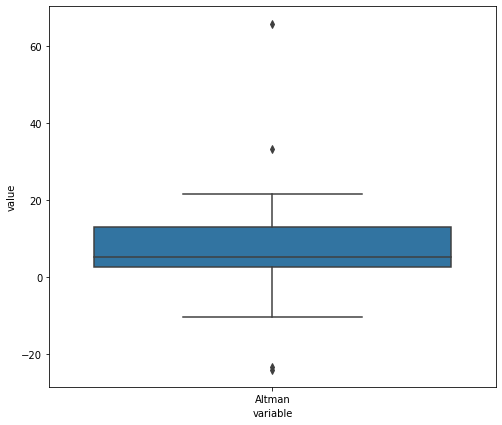

In [ ]:
df_altman = df_mean[['Altman']]
plt.figure(figsize=(8,7))
boxplot_altman = sns.boxplot(x='variable', y='value', data=pd.melt(df_altman))
plt.show()

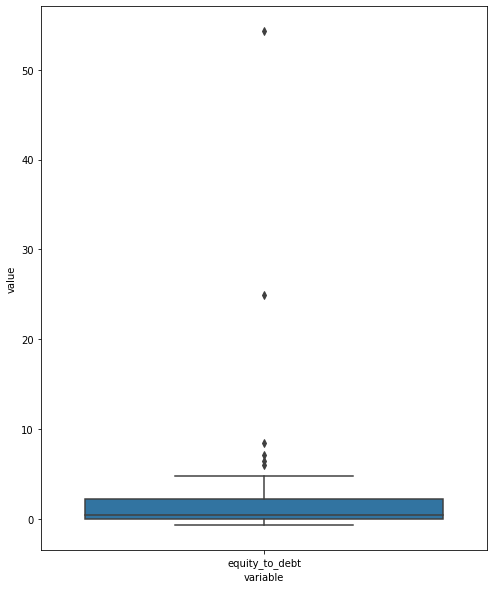

In [ ]:
df_borr = df_mean[['equity_to_debt']]
plt.figure(figsize=(8,10))
boxplot_borrowed_cap = sns.boxplot(x='variable', y='value', data=pd.melt(df_borr))
plt.show()

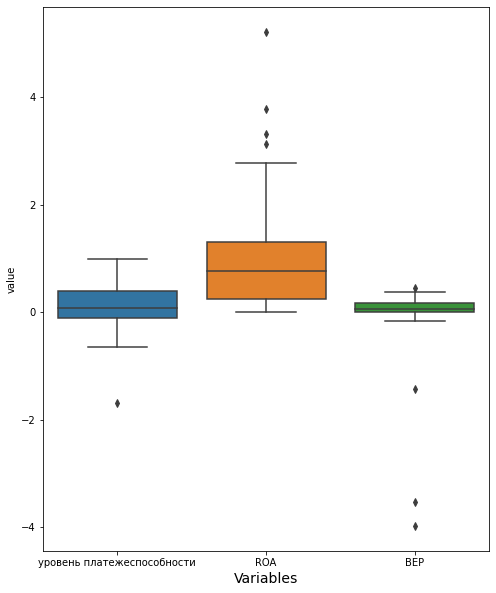

In [ ]:
df_other = df_mean[['уровень платежеспособности', 'ROA', 'BEP']]
plt.figure(figsize=(8,10))
boxplot_others = sns.boxplot(x='variable', y='value', data=pd.melt(df_other))
boxplot_others.set_xlabel('Variables', fontsize=14)
plt.show()

Теперь попробуем посмотреть на распределение коэффициента Альтмана и при визуальной оценке определить наименее и наиболее кредитоспосбные компании.

Основной вывод: 

Топ-3 наименее кредитоспосбных: 

1) СитиМобил

2) Информационное агентсво "Россия сегодня"

3) БЦ "Михайловский"

Топ-3 наиболее кредитоспособных: 

1) Фишер клиникал сервис (иностранная фарм компания)

2) Гаспром Единый Расчетный Сервис (идет как предприятие Гаспрома, поэтому высокая кредитоспособность вполне объяснима)

3) Мастеркард (иностранная платежная система, тут тоже более-менее очевидно)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


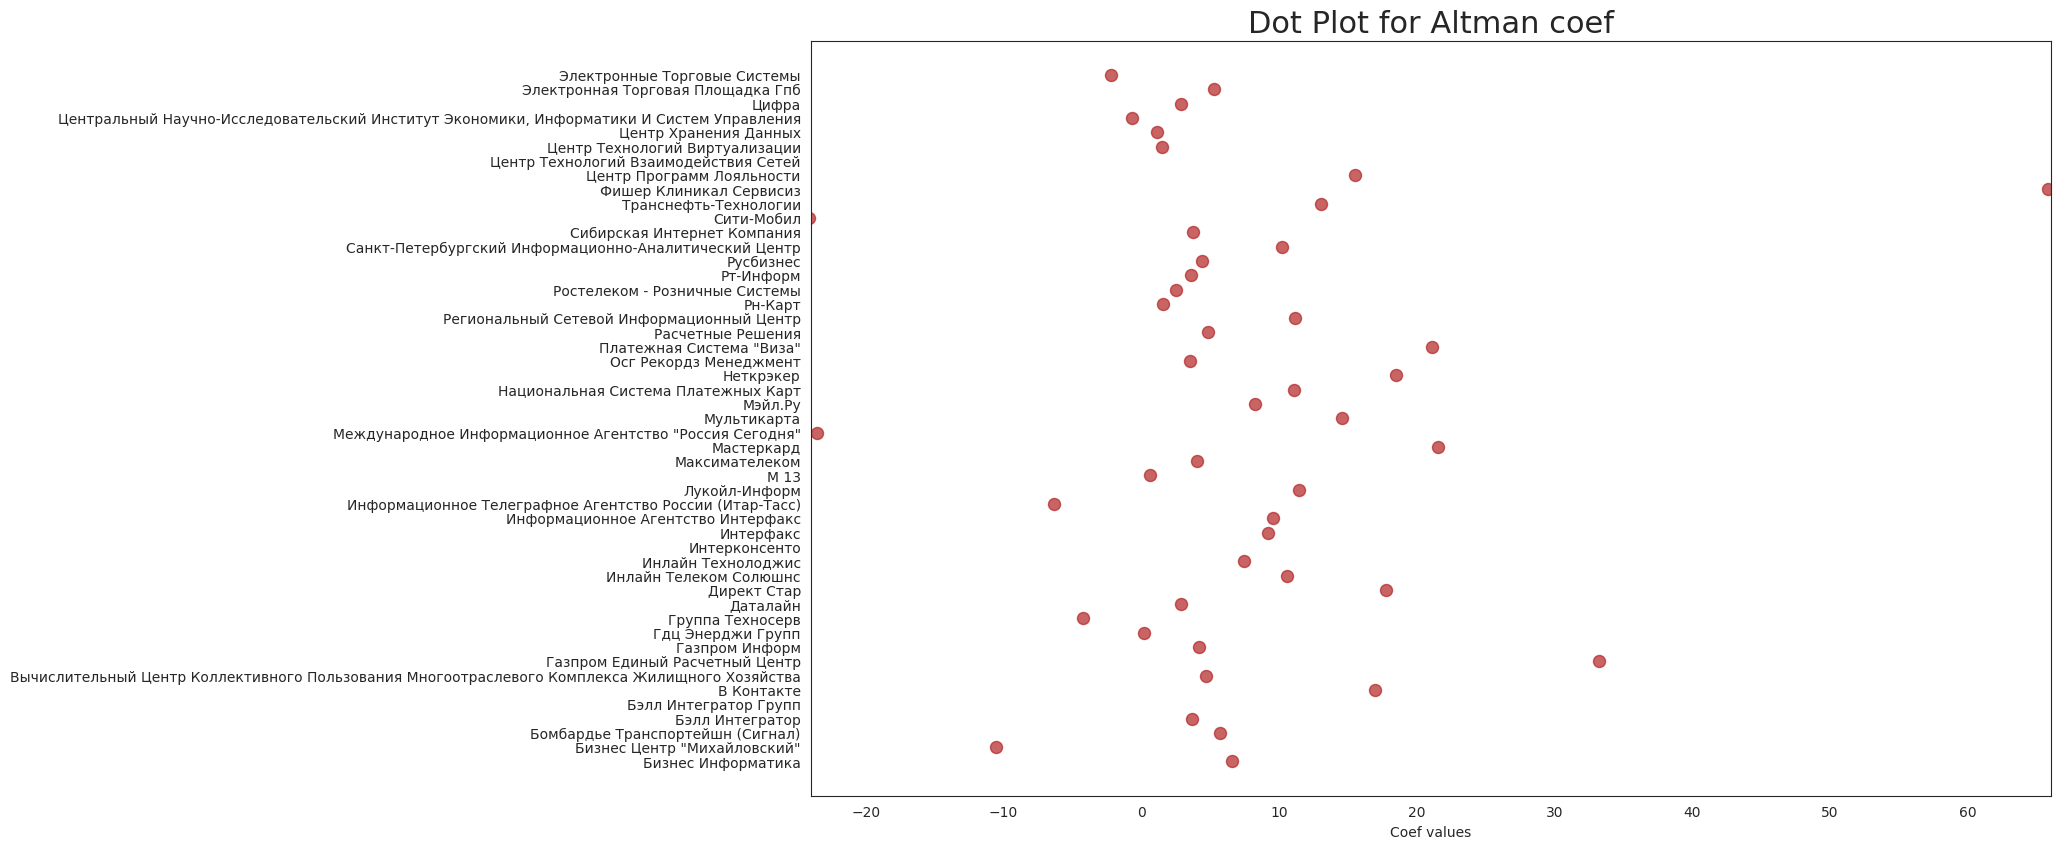

In [ ]:
df_tl = df_total[['title','Altman']].groupby('title').apply(lambda x: x.mean())
df_tl.reset_index(inplace=True)

# Сборка графика

fig, ax = plt.subplots(figsize=(16,10), dpi= 100)
ax.scatter(y=df_tl.index, x=df_tl.Altman, s=75, color='firebrick', alpha=0.7)

ax.set_title('Dot Plot for Altman coef', fontdict={'size':22})
ax.set_xlabel('Coef values')
ax.set_yticks(df_tl.index)
ax.set_yticklabels(df_tl.title.str.title(), fontdict={'horizontalalignment': 'right'})
ax.set_xlim(-24, 66)

plt.show()


Разберем отдельно наименее кредитоспособную компанию из выборки. 

Компания Сити-мобил имеет наихудший коэффициент Альтмана: на уровне -26. 

Каково положение компании относительно других? 

По данным видно, что по уровню платежеспособности, объему собственного капитала и относительно заемного компания значительно отстает от средних показателей отрасли.

Коэффициент базовой прибыльности активов крайне низок, о чем свидетельствует отрицательная операционная прибыль. Данная компания входит в число тех, которые занижают средние показатель внутри отрасли.

На значения показателей влияет операционная прибыль компании, что говорит о том, что у СитиМобил раходы значительно превышают расходы на уровне производства услуг. В данном случае, учитывая то, что компания является агрегатором сервиса такси, можно предположить, что её издержки обслучживания автопарков крайне велики. 

Однако, стоит заметить, что значение ROA в целом приближено к средним по отрасли. Вероятно высокий спрос на такси помогает достигать увеличенного уровня продаж.


In [ ]:
company = ['СИТИ-МОБИЛ']
df_total.loc[df_total['title'].isin(company)]

,title_en,title,region,ta_nonfix_fin,ta_nonfix,ta,debt_long,tp_long,debt_short,tp_short,sales,profit_oper,profit_before_tax,profit_after_tax,уровень платежеспособности,ROA,BEP,equity_to_debt,Altman
inn,,,,,,,,,,,,,,,,,,,
7728697453,SITI-MOBIL,СИТИ-МОБИЛ,77,0.018,0.988,1.012,0.0,0.0,0.913,1.531,1.069,-3.567,-3.632,-3.632,-0.536561,1.056324,-3.524704,-0.338994,-24.118177


Теперь стоит перейти к компаниям, которые могут считаться банкротами. 

Компаниями наиболее приближенными к банкротству можно считать те, которые имеют отрицательное значение коэффициента Альтмана. Как было видно из анализа СитиМобил, чаще всего на отрицательные значения влиет сразу несколько показателей. 

Если опираться на основное понимание дефолта, то это неспособность выплачивать обязательства. Если компания имеет отрицательную кредитоспособность, то её близость к дефолту очевидна. В данном случае компания проходит процедуру банкротства, поскольку неспособна обслужить весь свой заемный капитал.

Стоит заметить, что компания СитиМобил объявила себя банктором только в 2022 году, хотя, как видно из анализа, имела отрицательную кредитоспосбность еще в 2018 году. Вероятно данные компании не являются банкротами в период расммотрения, но уже близки к этому. 

Компании с отрицательным коффициентом Альтмана предсталены ниже:


In [ ]:
df_bancrupt = df_total.loc[df_total['Altman'] <= 0]
df_bancrupt['title']

inn
7728697453                                           СИТИ-МОБИЛ
7704853840    МЕЖДУНАРОДНОЕ ИНФОРМАЦИОННОЕ АГЕНТСТВО "РОССИЯ...
7722659420                          БИЗНЕС ЦЕНТР "МИХАЙЛОВСКИЙ"
7703082786    ИНФОРМАЦИОННОЕ ТЕЛЕГРАФНОЕ АГЕНТСТВО РОССИИ (И...
7727286517                                     ГРУППА ТЕХНОСЕРВ
7703668940                         ЭЛЕКТРОННЫЕ ТОРГОВЫЕ СИСТЕМЫ
7703824477    ЦЕНТРАЛЬНЫЙ НАУЧНО-ИССЛЕДОВАТЕЛЬСКИЙ ИНСТИТУТ ...
Name: title, dtype: object

Последнее, что стоит рассмотреть это зависмость между двумя переменными: ROA и BEP (Коэффициент базовой прибыльности активов). 

Оба показателя рассчитываются как отноение от объема активов, но обозначают немного разные понятия. ROA говорит о том, насколько эффективно предприятие распределяет свои оборотные и внеоборотные активы, в то время как BEP - сколько прибыли могут принести вложенные средства. 

Для начала данные были очищены от выбросов путем удаления значений, выходящих за пределы 1 и 3 квантилей.

Далее построен график линии регрессии, где в качестве зависимой переменной выступало ROA, а в качестве признака - BEP.

По графику видно, что преимущественно компании имеют значения ROA 1 и более, а BEP - менее 50%, что говроит о том, что несмотря на высокую эффективность распределения оборотных активов, вложенные средства приносят менее 50% прибыли.

Зависимость между переменными положительная, а коэффициент регрессии больше 0 и меньше 1, что говорит о том, что при увеличении BEP, ROA также растет, но незначительно. 

In [ ]:
df_short=df_total[:-3]

df_bep = df_short[['title','BEP']]
Q1_bep = df_bep['BEP'].quantile(0.25)
Q3_bep = df_bep['BEP'].quantile(0.75)
IQR_bep = Q1_bep-Q3_bep
df_bep=df_bep[(df_bep['BEP'] < Q1_bep-1.5*IQR_bep)|(df_bep['BEP'] > Q3_bep+1.5*IQR_bep)]['BEP']

df_roa = df_short[['title','ROA']]
Q1_roa = df_roa['ROA'].quantile(0.25)
Q3_roa = df_roa['ROA'].quantile(0.75)
IQR_roa = Q1_roa-Q3_roa
df_roa=df_roa[(df_roa['ROA'] < Q1_roa-1.5*IQR_roa)|(df_roa['ROA'] > Q3_roa+1.5*IQR_roa)]['ROA']

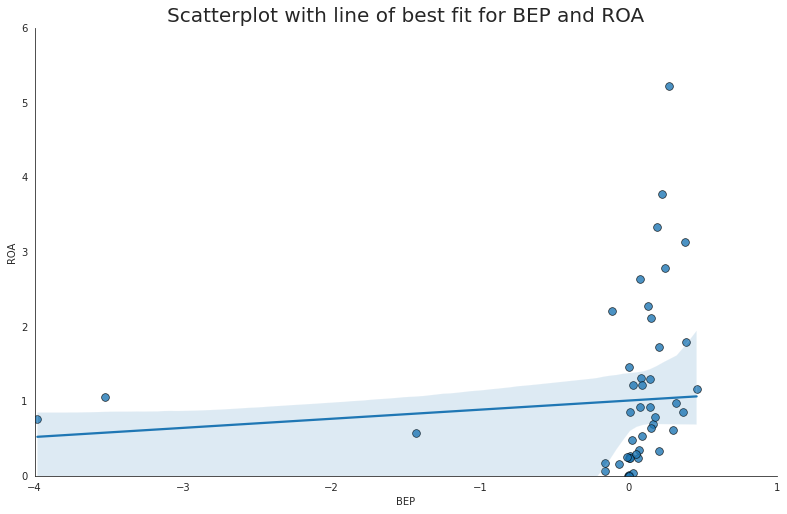

In [ ]:
df_reg = pd.merge(df_bep, df_roa, how = 'inner', left_index=True, right_index=True)
df_reg

sns.set_style('white')
gridobj = sns.lmplot(x='BEP', y='ROA', data=df_reg, 
                     height=7, aspect=1.6, robust=True, palette='tab10', 
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))

# Decorations
gridobj.set(xlim=(-4, 1), ylim=(0, 6))
plt.title('Scatterplot with line of best fit for BEP and ROA', fontsize=20)
plt.show()
